# Preparing and Combining Data from Web API and Web Scraping

### Imports

In [3]:
from pandas import json_normalize
import requests
import json
import os
import re
import time
import fnmatch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
from pandas.io import sql
from sqlalchemy import create_engine
import pymysql
pymysql.install_as_MySQLdb()

### Start Connection to MYSQL and Create Table for Tax Rates and BfS Query Table

In [4]:
mydb = pymysql.connect(
  host="localhost",
  user="root",
  password="nh1hgE6L$1")

print(mydb)

# Create data base
cursor = mydb.cursor()
cursor.execute("CREATE DATABASE IF NOT EXISTS projectDA_database")

# Show data bases in my sql
cursor.execute("SHOW DATABASES")

for x in cursor:
  print(x)



('eatily',)
('exercise',)
('infections',)
('information_schema',)
('mysql',)
('performance_schema',)
('projectda_database',)
('projectthree',)
('projectx',)


In [5]:
conn = pymysql.connect(
host="localhost",
user="root",
password="nh1hgE6L$1",
database="projectda_database")

print(conn)

cursor = conn.cursor()

db_data = 'mysql+mysqldb://' + 'root' + ':' + 'nh1hgE6L$1' + '@' + 'localhost' + ':3306/' \
       + 'projectda_database' + '?charset=utf8mb4'
engine = create_engine(db_data)

# Connect to the database
connection = pymysql.connect(host='localhost',
                         user='root',
                         password='nh1hgE6L$1',
                         db='projectda_database')   

In [6]:
# Create SQL-table Steuerfuss in the database
cursor.execute('''CREATE TABLE IF NOT EXISTS steuerfuss_table (id INT AUTO_INCREMENT PRIMARY KEY,
                                                               Kanton VARCHAR(50),
                                                               BfSId INT(20),
                                                               Gemeinde VARCHAR(50),
                                                               Kantonssteuerfuss DECIMAL(5,2),
                                                               Gemeindesteuerfuss DECIMAL(5,2))''')
# Confirm changes to the table
conn.commit()

# Create SQL-table BFS and Gemeinde in the database
cursor.execute('''CREATE TABLE IF NOT EXISTS bfs_gemeinde_table (id INT AUTO_INCREMENT PRIMARY KEY,
                                                               Ortschaftsname VARCHAR(50),
                                                               PLZ INT(20),
                                                               Zusatzziffer INT(20),
                                                               Gemeindename VARCHAR(50),
                                                               BfS_Id INT(20),
                                                               Kantonskürzel VARCHAR(50))''')
# Confirm changes to the table
conn.commit()


### Load Tax Rates

In [7]:
df_steuerfuss = pd.read_excel('../03_Collecting Data/01_Web API/estv_income_rates.xlsx', 
                           sheet_name='Export')

steuersatz_kombiniert = []

for index,row in df_steuerfuss.iterrows():
    number = row['Gemeindesteuerfuss'] + row['Kantonssteuerfuss']
    steuersatz_kombiniert.append(number)

df_steuerfuss['steuersatz_kombiniert'] = steuersatz_kombiniert
df_steuerfuss.head(5)

,Kantons-Id,Kanton,BfS_Id,Gemeinde,Kantonssteuerfuss,Gemeindesteuerfuss,Kirche ref.,Kirche röm.-kt.,Kirche christkt.,Kanton.1,...,Kirche ref..1,Kirche röm.-kt..1,Kirche christkt..1,Kanton.2,Gemeinde.2,Kirche,Kanton.3,Gemeinde.3,Kirche.1,steuersatz_kombiniert
0,1,ZH,21,Adlikon,99.0,126.0,12.0,14.0,14.0,99.0,...,12.0,14.0,14.0,99.0,138.32,0.0,99.0,138.32,0.0,225.0
1,1,ZH,131,Adliswil,99.0,102.0,10.0,8.0,14.0,99.0,...,10.0,8.0,14.0,99.0,108.86,0.0,99.0,108.86,0.0,201.0
2,1,ZH,241,Aesch (ZH),99.0,89.0,11.0,11.0,14.0,99.0,...,11.0,11.0,14.0,99.0,100.00,0.0,99.0,100.00,0.0,188.0
3,1,ZH,1,Aeugst am Albis,99.0,95.0,12.0,13.0,14.0,99.0,...,12.0,13.0,14.0,99.0,107.34,0.0,99.0,107.34,0.0,194.0
4,1,ZH,2,Affoltern am Albis,99.0,124.0,12.0,13.0,14.0,99.0,...,12.0,13.0,14.0,99.0,136.50,0.0,99.0,136.50,0.0,223.0


### Load BfS Table to match PLZ to BfS-Ids

In [8]:
df_bfs_gemeinde = pd.read_csv('../03_Collecting Data/01_Web API/PLZ_BFS.csv', sep=';', encoding='utf-8')
print(df_bfs_gemeinde.shape)
df_bfs_gemeinde.head(5)

(4126, 9)


,Ortschaftsname,PLZ,Zusatzziffer,Gemeindename,BfS_Id,Kantonskürzel,E,N,Sprache
0,Aeugst am Albis,8914,0,Aeugst am Albis,1,ZH,8.488313,47.267004,de
1,Aeugstertal,8914,2,Aeugst am Albis,1,ZH,8.493642,47.282761,de
2,Zwillikon,8909,0,Affoltern am Albis,2,ZH,8.431459,47.287633,de
3,Affoltern am Albis,8910,0,Affoltern am Albis,2,ZH,8.448945,47.279169,de
4,Bonstetten,8906,0,Bonstetten,3,ZH,8.467611,47.315510,de


### Define Fields for Database Upload

In [9]:
df_for_database = pd.read_excel('../03_Collecting Data/01_Web API/estv_income_rates.xlsx', 
                           sheet_name='Export')[['BfS_Id', 'Kanton', 'Gemeinde', 'Kantonssteuerfuss', 'Gemeindesteuerfuss']]
print(df_for_database.shape)
df_for_database.head(5)

(2149, 5)


,BfS_Id,Kanton,Gemeinde,Kantonssteuerfuss,Gemeindesteuerfuss
0,21,ZH,Adlikon,99.0,126.0
1,131,ZH,Adliswil,99.0,102.0
2,241,ZH,Aesch (ZH),99.0,89.0
3,1,ZH,Aeugst am Albis,99.0,95.0
4,2,ZH,Affoltern am Albis,99.0,124.0


In [10]:
df_for_database_gemeinde = pd.read_csv('../03_Collecting Data/01_Web API/PLZ_BFS.csv', sep=';', encoding='utf-8')[['Ortschaftsname', 'PLZ', 'Zusatzziffer', 'Gemeindename', 'BfS_Id', 'Kantonskürzel']]
print(df_for_database_gemeinde.shape)
df_for_database_gemeinde.head(5)

(4126, 6)


,Ortschaftsname,PLZ,Zusatzziffer,Gemeindename,BfS_Id,Kantonskürzel
0,Aeugst am Albis,8914,0,Aeugst am Albis,1,ZH
1,Aeugstertal,8914,2,Aeugst am Albis,1,ZH
2,Zwillikon,8909,0,Affoltern am Albis,2,ZH
3,Affoltern am Albis,8910,0,Affoltern am Albis,2,ZH
4,Bonstetten,8906,0,Bonstetten,3,ZH


### Write data to the SQL-table in data base

In [11]:

# Execute the to_sql for writting DF into SQL
df_for_database_gemeinde.to_sql('bfs_gemeinde_table', engine, if_exists='replace', index=False)    

# Execute query
sql = "SELECT * FROM `bfs_gemeinde_table`"
cursor.execute(sql)

# Fetch all the records
result = cursor.fetchall()
for i in result:
    print(i)

engine.dispose()

('Aeugst am Albis', 8914, 0, 'Aeugst am Albis', 1, 'ZH')
('Aeugstertal', 8914, 2, 'Aeugst am Albis', 1, 'ZH')
('Zwillikon', 8909, 0, 'Affoltern am Albis', 2, 'ZH')
('Affoltern am Albis', 8910, 0, 'Affoltern am Albis', 2, 'ZH')
('Bonstetten', 8906, 0, 'Bonstetten', 3, 'ZH')
('Hausen am Albis', 8915, 0, 'Hausen am Albis', 4, 'ZH')
('Ebertswil', 8925, 0, 'Hausen am Albis', 4, 'ZH')
('Hedingen', 8908, 0, 'Hedingen', 5, 'ZH')
('Kappel am Albis', 8926, 0, 'Kappel am Albis', 6, 'ZH')
('Hauptikon', 8926, 2, 'Kappel am Albis', 6, 'ZH')
('Uerzlikon', 8926, 3, 'Kappel am Albis', 6, 'ZH')
('Knonau', 8934, 0, 'Knonau', 7, 'ZH')
('Maschwanden', 8933, 0, 'Maschwanden', 8, 'ZH')
('Mettmenstetten', 8932, 0, 'Mettmenstetten', 9, 'ZH')
('Obfelden', 8912, 0, 'Obfelden', 10, 'ZH')
('Ottenbach', 8913, 0, 'Ottenbach', 11, 'ZH')
('Rifferswil', 8911, 0, 'Rifferswil', 12, 'ZH')
('Stallikon', 8143, 0, 'Stallikon', 13, 'ZH')
('Uetliberg', 8143, 2, 'Stallikon', 13, 'ZH')
('Wettswil', 8907, 0, 'Wettswil am Albis', 

In [12]:

# create cursor
cursor=connection.cursor()
# Execute the to_sql for writting DF into SQL
df_for_database.to_sql('steuerfuss_table', engine, if_exists='replace', index=False)    

# Execute query
sql = "SELECT * FROM `steuerfuss_table`"
cursor.execute(sql)

# Fetch all the records
result = cursor.fetchall()
for i in result:
    print(i)

engine.dispose()

(21, 'ZH', 'Adlikon', 99.0, 126.0)
(131, 'ZH', 'Adliswil', 99.0, 102.0)
(241, 'ZH', 'Aesch (ZH)', 99.0, 89.0)
(1, 'ZH', 'Aeugst am Albis', 99.0, 95.0)
(2, 'ZH', 'Affoltern am Albis', 99.0, 124.0)
(211, 'ZH', 'Altikon', 99.0, 114.0)
(30, 'ZH', 'Andelfingen', 99.0, 114.0)
(51, 'ZH', 'Bachenbülach', 99.0, 106.0)
(81, 'ZH', 'Bachs', 99.0, 127.0)
(52, 'ZH', 'Bassersdorf', 99.0, 114.0)
(297, 'ZH', 'Bauma', 99.0, 120.0)
(22, 'ZH', 'Benken (ZH)', 99.0, 114.0)
(23, 'ZH', 'Berg am Irchel', 99.0, 98.0)
(242, 'ZH', 'Birmensdorf (ZH)', 99.0, 112.0)
(3, 'ZH', 'Bonstetten', 99.0, 109.0)
(82, 'ZH', 'Boppelsen', 99.0, 94.0)
(213, 'ZH', 'Brütten', 99.0, 89.0)
(112, 'ZH', 'Bubikon', 99.0, 118.0)
(24, 'ZH', 'Buch am Irchel', 99.0, 106.0)
(83, 'ZH', 'Buchs (ZH)', 99.0, 110.0)
(111, 'ZH', 'Bäretswil', 99.0, 106.0)
(53, 'ZH', 'Bülach', 99.0, 110.0)
(25, 'ZH', 'Dachsen', 99.0, 112.0)
(86, 'ZH', 'Dielsdorf', 99.0, 105.0)
(243, 'ZH', 'Dietikon', 99.0, 123.0)
(54, 'ZH', 'Dietlikon', 99.0, 102.0)
(216, 'ZH', 'Din

### Query the SQL-table

In [13]:
# Query the SQL-table
cursor.execute('''SELECT * FROM steuerfuss_table
                  WHERE Kanton = "AG"
                  AND Gemeindesteuerfuss > 110''')

df = pd.DataFrame(cursor.fetchall(), 
                  columns=['Bfs-Nr','Kanton','Gemeinde','Kantonssteuerfuss','Gemeindesteuerfuss'])    
print(df)

    Bfs-Nr Kanton    Gemeinde  Kantonssteuerfuss  Gemeindesteuerfuss
0     4271     AG     Aarburg              112.0               121.0
1     4221     AG      Abtwil              112.0               115.0
2     4223     AG         Auw              112.0               112.0
3     4226     AG  Besenbüren              112.0               113.0
4     4092     AG        Birr              112.0               117.0
..     ...    ...         ...                ...                 ...
78    4183     AG      Zeihen              112.0               114.0
79    4263     AG   Zeiningen              112.0               112.0
80    4147     AG     Zetzwil              112.0               118.0
81    4324     AG     Zurzach              112.0               115.0
82    4264     AG      Zuzgen              112.0               119.0

[83 rows x 5 columns]


## Plot histogramm of Kantonssteuerfuss and Gemeindesteuerfuss

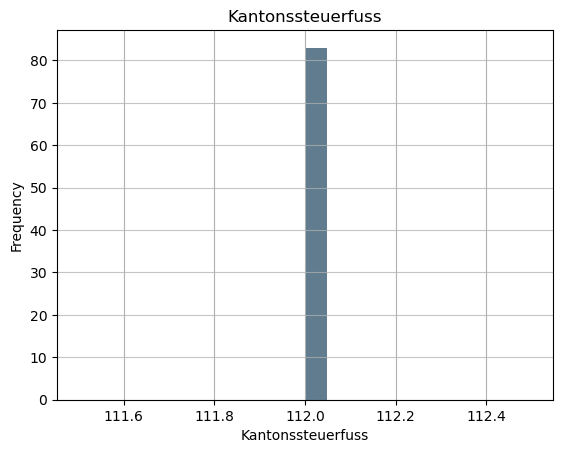

In [14]:
df.Kantonssteuerfuss.plot.hist(grid=True, 
                   bins=20, 
                   rwidth=0.9,
                   color='#607c8e')
plt.title('Kantonssteuerfuss')
plt.xlabel('Kantonssteuerfuss')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

#conn.close()b

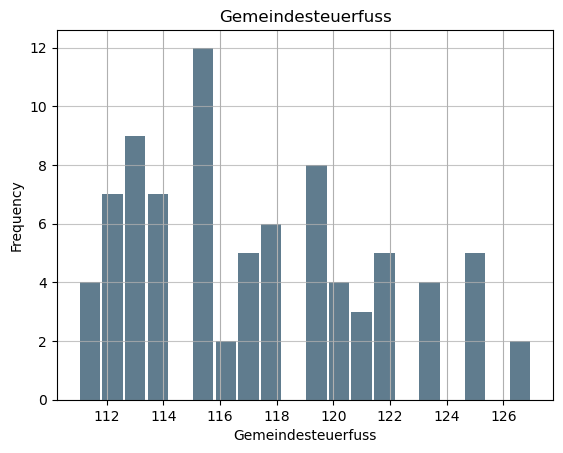

In [15]:
df.Gemeindesteuerfuss.plot.hist(grid=True, 
                   bins=20, 
                   rwidth=0.9,
                   color='#607c8e')
plt.title('Gemeindesteuerfuss')
plt.xlabel('Gemeindesteuerfuss')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

#conn.close()

## Importing Web Scraping Dataset from Homegate

In [16]:
df_apartments = pd.read_csv('../03_Collecting Data/02_Web Scraping/dataset_homegate_raw.csv', sep=',', encoding='utf-8')
df_apartments.head(5)

,web-scraper-order,web-scraper-start-url,price_raw,qubic_meter_raw,rooms_raw,full_address,description,type
0,1672673926-34302,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’000’000.–,110m2,3.5Zi,6963 Pregassona,In zona residenziale tranquilla e soleggiata p...,Wohnung
1,1672673920-34265,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’010’000.–,124m2,4.5Zi,"Bahnweg, 8862 Schübelbach","In der neuen Überbauung ""Parco Verde"" entstehe...",Wohnung
2,1672673926-34300,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’010’000.–,109m2,4.5Zi,4133 Pratteln,RUDERHOLZ - Nahe Rhein und Ergolz in AugstDie ...,Wohnung
3,1672673926-34314,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’020’000.–,122m2,4.5Zi,"Höhenweg 6, 9424 Rheineck",Ab Frühsommer 2023 werden am Höhenweg 6 in Rhe...,Wohnung
4,1672673923-34296,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’030’000.–,154m2,5.5Zi,"Schuderserstrasse 3, 7220 Schiers","Die attraktive, brandneue 5.5-Zimmer-Erdgescho...",Wohnung


Count number of rows and columns in the data frame

In [17]:
#Dimension (rows, columns)
print('Dimension: ', df_apartments.shape)

#Number of Rows
print('Number of Rows: ', df_apartments.shape[0])

#Number of Columns
print('Number of Columns: ', df_apartments.shape[1])

Dimension:  (14040, 8)
Number of Rows:  14040
Number of Columns:  8


Get Data Types (raw-format from web scraping)

In [18]:
# Get data types
df_apartments.dtypes

web-scraper-order        object
web-scraper-start-url    object
price_raw                object
qubic_meter_raw          object
rooms_raw                object
full_address             object
description              object
type                     object
dtype: object

Extract and Save relevant information from raw data using regular expressions

Extract number of rooms

In [19]:
rooms = []

for i in df_apartments['rooms_raw']:

    if "Zi" in str(i):
        temp = i.strip("Zi")
        rooms.append(float(temp))
        
    else:
        rooms.append("nan")

print(len(rooms))

df_apartments['rooms'] = pd.Series(rooms, dtype="Float32")
print(df_apartments['rooms_raw'].head(5), '\n')
print(df_apartments['rooms'].head(5))


14040
0    3.5Zi
1    4.5Zi
2    4.5Zi
3    4.5Zi
4    5.5Zi
Name: rooms_raw, dtype: object 

0    3.5
1    4.5
2    4.5
3    4.5
4    5.5
Name: rooms, dtype: Float32


Extract Area of rooms

In [20]:
# Extract values from 'dataset_homegate_raw.csv' strings
area = []
#Problem 1 Strip nimmt alles weg, was passt, muss spezifiziert werden: gelöst durch replace, evtl. geht auch rstrip
#Problem 2 String hat teilweise noch Dezimaltrenner ’ drin
for i in df_apartments['qubic_meter_raw']:
     
    try:
        if "m2" in str(i):
            qubic_meter = i.replace("m2","")
            qubic_meter = qubic_meter.replace("’","")
            area.append(int(qubic_meter))
        else:
            area.append(None)
    except:
        print(i)  
        
print(len(area))

# Save as new variable in the pandas data frame
df_apartments['area'] = pd.Series(area, dtype="Int64")

# Print first 5 values
print(df_apartments['qubic_meter_raw'].head(5), '\n')
print(df_apartments['area'].head(5))

14040
0    110m2
1    124m2
2    109m2
3    122m2
4    154m2
Name: qubic_meter_raw, dtype: object 

0    110
1    124
2    109
3    122
4    154
Name: area, dtype: Int64


Extract Price

In [21]:
# Extract values from 'dataset_homegate_raw.csv' strings
price = []
for i in df_apartments['price_raw']:
     
    try:
        if ".–" in str(i):
            price_modify = i.replace(".–","")
            price_modify = price_modify.replace("’","")
            price.append(int(price_modify))
        else:
            price.append(None)
    except:
        print(i)  
        
print(len(price))

# Save as new variable in the pandas data frame
df_apartments['price'] = pd.Series(price, dtype="Int64")

# Print first 5 values
print(df_apartments['price_raw'].head(5), '\n')
print(df_apartments['price'].head(5))

14040
0    1’000’000.–
1    1’010’000.–
2    1’010’000.–
3    1’020’000.–
4    1’030’000.–
Name: price_raw, dtype: object 

0    1000000
1    1010000
2    1010000
3    1020000
4    1030000
Name: price, dtype: Int64


Extract PLZ Code

In [22]:
#Max Version
import re
from string import digits

plz = []
street = []


for i in df_apartments['full_address']:
    try:
        if i !="":
            #rsplit mit max. 1, damit komische Aufzählungen nichts verfälschen
            adresslist=i.rsplit(",",1)
            if len(adresslist)>1:
                
                #Die Strassen haben manchmal /1/2/3 drin oder 1,2,3,4, das wird hier weggenommen
                
                plz.append(int(re.findall(r'\d+', adresslist[1].strip())[0]))
                tempStreet=adresslist[0].split("/")
                tempStreet=tempStreet[0].split(",")                
                street.append(tempStreet[0].strip())
                
                #es gibt nie die Kombination von nur einer Strasse, aber keiner PLZ
            #elif len(adresslist)==1:
            else:
                plz.append(re.findall(r'\d+', adresslist[0].strip())[0])
                street.append(" ")
        else:
            plz.append(None)
            street.append(" ")
    except:
        #Überlegung: Es gibt insgesamt 8 Werte, die mehrere Kommas von hinten haben. Alle haben keine Strasse
        #Option 1: Werte händisch bereinigen in Liste
        #Option 2: siehe unten
        plz.append(int(re.findall(r'\d+', i)[0]))
        street.append(" ")
        
df_apartments['PLZ'] = pd.Series(plz, dtype="Int64")               
df_apartments['Street'] = pd.Series(street, dtype="str") 

# Print first 5 values
#print(df_apartments.head(5), '\n')
#print(df_apartments['Street'].head(5))



Get data types of all variables including the new ones

In [23]:
df_apartments.dtypes


web-scraper-order         object
web-scraper-start-url     object
price_raw                 object
qubic_meter_raw           object
rooms_raw                 object
full_address              object
description               object
type                      object
rooms                    Float32
area                       Int64
price                      Int64
PLZ                        Int64
Street                    object
dtype: object

## Count and Identify missing values

In [24]:
# Count missing values
print('Count missing values per variable')
print (pd.isna(df_apartments).sum(), '\n')

# Identify row with missing values
print('Identify rows with missing values')
print(df_apartments.loc[df_apartments.isna().any(axis=1)][['rooms', 'area', 'price']], '\n')


# Drop rows where at least one element is missing (room, area or price).
df2_appartments = df_apartments.dropna(subset=['rooms_raw', 'area', 'price'])  
df2_appartments.drop(df2_appartments[df2_appartments['area'] < 10].index, inplace=True)
df2_appartments.drop(df2_appartments[df2_appartments['price'] < 29500].index, inplace=True)
df2_appartments.head(5)

Count missing values per variable
web-scraper-order           0
web-scraper-start-url       0
price_raw                1328
qubic_meter_raw          1215
rooms_raw                 765
full_address                0
description                33
type                        0
rooms                       0
area                     1215
price                    1328
PLZ                         0
Street                      0
dtype: int64 

Identify rows with missing values
       rooms  area    price
42       3.5  <NA>  1195000
60       5.5  <NA>  1270000
71       4.5  <NA>  1310000
79       4.5  <NA>  1370000
110      NaN  <NA>  1480000
...      ...   ...      ...
14014    5.5   215     <NA>
14017    5.5  <NA>   750000
14021    NaN   252   970000
14025    4.5  <NA>  1950000
14033    NaN  <NA>     <NA>

[2668 rows x 3 columns] 



C:\Users\kolle\AppData\Local\Temp\ipykernel_20260\2727484708.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_appartments.drop(df2_appartments[df2_appartments['area'] < 10].index, inplace=True)
C:\Users\kolle\AppData\Local\Temp\ipykernel_20260\2727484708.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_appartments.drop(df2_appartments[df2_appartments['price'] < 29500].index, inplace=True)


,web-scraper-order,web-scraper-start-url,price_raw,qubic_meter_raw,rooms_raw,full_address,description,type,rooms,area,price,PLZ,Street
0,1672673926-34302,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’000’000.–,110m2,3.5Zi,6963 Pregassona,In zona residenziale tranquilla e soleggiata p...,Wohnung,3.5,110,1000000,6963,
1,1672673920-34265,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’010’000.–,124m2,4.5Zi,"Bahnweg, 8862 Schübelbach","In der neuen Überbauung ""Parco Verde"" entstehe...",Wohnung,4.5,124,1010000,8862,Bahnweg
2,1672673926-34300,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’010’000.–,109m2,4.5Zi,4133 Pratteln,RUDERHOLZ - Nahe Rhein und Ergolz in AugstDie ...,Wohnung,4.5,109,1010000,4133,
3,1672673926-34314,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’020’000.–,122m2,4.5Zi,"Höhenweg 6, 9424 Rheineck",Ab Frühsommer 2023 werden am Höhenweg 6 in Rhe...,Wohnung,4.5,122,1020000,9424,Höhenweg 6
4,1672673923-34296,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’030’000.–,154m2,5.5Zi,"Schuderserstrasse 3, 7220 Schiers","Die attraktive, brandneue 5.5-Zimmer-Erdgescho...",Wohnung,5.5,154,1030000,7220,Schuderserstrasse 3


## Count and Identify duplicated values (if any)

In [25]:
# Count duplicated values in the whole data set
print('Sum of missing values:', df_apartments.duplicated().sum(), '\n')

# Identify rows with duplicated values
print('Duplicated values')
print(df_apartments.loc[df_apartments.duplicated(keep = 'last')])

# Drop the rows with duplicated values
df3_apartments = df2_appartments.drop_duplicates()

Sum of missing values: 0 

Duplicated values
Empty DataFrame
Columns: [web-scraper-order, web-scraper-start-url, price_raw, qubic_meter_raw, rooms_raw, full_address, description, type, rooms, area, price, PLZ, Street]
Index: []


In [26]:
#Dimension (rows, columns)
print('Dimension: ', df3_apartments.shape)

#Number of Rows
print('Number of Rows: ', df3_apartments.shape[0])

#Number of Columns
print('Number of Columns: ', df3_apartments.shape[1])

Dimension:  (11391, 13)
Number of Rows:  11391
Number of Columns:  13


## Create additional variables from the dataset Homegate descriptions

### Change strings in 'description_raw' to uppercase

In [27]:
# Change strings to uppercase 
df3_apartments['description'] = df3_apartments['description'].str.upper()
print(df3_apartments['description'].head(10), '\n')

0    IN ZONA RESIDENZIALE TRANQUILLA E SOLEGGIATA P...
1    IN DER NEUEN ÜBERBAUUNG "PARCO VERDE" ENTSTEHE...
2    RUDERHOLZ - NAHE RHEIN UND ERGOLZ IN AUGSTDIE ...
3    AB FRÜHSOMMER 2023 WERDEN AM HÖHENWEG 6 IN RHE...
4    DIE ATTRAKTIVE, BRANDNEUE 5.5-ZIMMER-ERDGESCHO...
5    DAS SPANNENDE DURCHSCHLUSSLOFT MIT GROSSZÜGIGE...
6    OBJEKTBESCHREIBUNGZUM VERKAUF STEHT DIESE SONN...
7    AN RUHIGER, LEICHT ERHÖHTER LAGE ENTSTEHEN IN ...
8    MODERN LEBEN AUF DEM LAND - NEUBAU MIT 12 EIGE...
9    MODERN LEBEN AUF DEM LAND - NEUBAU MIT 12 EIGE...
Name: description, dtype: object 



### Calculate lenght of strings in 'description_raw'

In [28]:
# Show first item of variable 'description'
print(df3_apartments['description'])

# Lenght of the strings in 'description'
df3_apartments['description_len'] = df3_apartments['description'].str.len()
print(df3_apartments['description_len'], '\n')

0        IN ZONA RESIDENZIALE TRANQUILLA E SOLEGGIATA P...
1        IN DER NEUEN ÜBERBAUUNG "PARCO VERDE" ENTSTEHE...
2        RUDERHOLZ - NAHE RHEIN UND ERGOLZ IN AUGSTDIE ...
3        AB FRÜHSOMMER 2023 WERDEN AM HÖHENWEG 6 IN RHE...
4        DIE ATTRAKTIVE, BRANDNEUE 5.5-ZIMMER-ERDGESCHO...
                               ...                        
14035    EXPOSITION EXCEPTIONNELLE POUR CETTE VILLA QUI...
14036    DISPONIBLE RAPIDEMENT, À SAISIR !MAGNIFIQUE VI...
14037    DAS 5½ ZI.-ECKEINFAMILIENHAUS IN ARLESHEIM LIE...
14038    NEL CARATTERISTICO E VERDE BORGO DI AROGNO, A ...
14039    AD AROGNO, IN ZONA ESTREMAMENTE STRATEGICA, VI...
Name: description, Length: 11391, dtype: object
0        1059.0
1        1451.0
2        1973.0
3         690.0
4        1501.0
          ...  
14035     653.0
14036    2171.0
14037    1254.0
14038     827.0
14039    1316.0
Name: description_len, Length: 11391, dtype: float64 



### Create new binary (0/1) variables 'luxurious', 'furnished', 'balcony', 'garden', 'quiet', 'central'

In [29]:
# Create a pattern which can be used to search the variable 'description'
pattern = '(LOFT)|(SEESICHT)|(ATTIKA)|(LUXURIÖS)|(POOL)|(EXKLUSIV)|(MARE)|(LUSSUOSO)|(MER)|(LUXE)|(PISCINE)|(EXCLUSIF)|(ETRAVAGANT)|(LUXURIOUS)|(EXCLUSIVE)'
patternFurnished = '(MÖBILIERT)|(FURNISHED)|(MEUBLÉ)|(AMEUBLEMENT)|(ARREDATO)|(ARREDATA)|(ARREDATI)'
patternBalcony = '(BALKON)|(TERRASSE)|(LOGGIA)|(VERANDA)|(GALERIE)|(BALCONE)|(TERRAZZA)|(GALLERIA)|(BALCON)'
patternGarden = '(GARTEN)|(SITZPLATZ)|(GARTENANLAGE)|(JARDIN)|(SIEGE)|(ANNEXE)|(GIARDINO)|(SEAT)|(GIARDINIERA)'
patternQuiet = '(RUHIG)|(GERÄUSCHLOS)|(GERÄUSCHARM)|(STILL)|(SCHALLGEDÄMPFT)|(SILENZIO)|(SILENZIATO)|(TACITO)|(SILENCIEUX)|(INSONORISÉ)|(SILENCIEUSE)|(SILENCE)|(SONORE)|(QUIET)|(NOISELESS)|(SILENT)|(SILENCED)'
patternCentral = '(IM ZENTRUM)|(ZENTRAL)|(IM HERZEN)|(ZENTRALE LAGE)|(INMITTEN)|(CENTRAL)|(HEART)|(MIDDLE)|(CENTRE)|(CENTRALE)|(CENTRO)|(MEZZO)|(CENTRALE)'

# Create new variable 'luxurious' as binary dummy (0/1) variable
df3_apartments['luxurious'] = df3_apartments['description'].str.contains(pat = pattern).astype(float)
print(df3_apartments['luxurious'].sum())
df3_apartments['furnished'] = df3_apartments['description'].str.contains(pat = patternFurnished).astype(float)
print(df3_apartments['furnished'].sum())
df3_apartments['balcony'] = df3_apartments['description'].str.contains(pat = patternBalcony).astype(float)
print(df3_apartments['balcony'].sum())
df3_apartments['garden'] = df3_apartments['description'].str.contains(pat = patternGarden).astype(float)
print(df3_apartments['garden'].sum())
df3_apartments['quiet'] = df3_apartments['description'].str.contains(pat = patternQuiet).astype(float)
print(df3_apartments['quiet'].sum())
df3_apartments['central'] = df3_apartments['description'].str.contains(pat = patternCentral).astype(float)
print(df3_apartments['central'].sum())

# Show values
df3_apartments[['description','rooms','area','price','luxurious', 'furnished', 'balcony', 'garden', 'quiet', 'central']]

C:\Users\kolle\AppData\Local\Temp\ipykernel_20260\24394972.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df3_apartments['luxurious'] = df3_apartments['description'].str.contains(pat = pattern).astype(float)


8483.0


C:\Users\kolle\AppData\Local\Temp\ipykernel_20260\24394972.py:12: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df3_apartments['furnished'] = df3_apartments['description'].str.contains(pat = patternFurnished).astype(float)


336.0


C:\Users\kolle\AppData\Local\Temp\ipykernel_20260\24394972.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df3_apartments['balcony'] = df3_apartments['description'].str.contains(pat = patternBalcony).astype(float)


7719.0


C:\Users\kolle\AppData\Local\Temp\ipykernel_20260\24394972.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df3_apartments['garden'] = df3_apartments['description'].str.contains(pat = patternGarden).astype(float)


5561.0


C:\Users\kolle\AppData\Local\Temp\ipykernel_20260\24394972.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df3_apartments['quiet'] = df3_apartments['description'].str.contains(pat = patternQuiet).astype(float)


2247.0


C:\Users\kolle\AppData\Local\Temp\ipykernel_20260\24394972.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df3_apartments['central'] = df3_apartments['description'].str.contains(pat = patternCentral).astype(float)


4127.0


,description,rooms,area,price,luxurious,furnished,balcony,garden,quiet,central
0,IN ZONA RESIDENZIALE TRANQUILLA E SOLEGGIATA P...,3.5,110,1000000,1.0,0.0,0.0,1.0,0.0,0.0
1,"IN DER NEUEN ÜBERBAUUNG ""PARCO VERDE"" ENTSTEHE...",4.5,124,1010000,1.0,0.0,1.0,0.0,0.0,1.0
2,RUDERHOLZ - NAHE RHEIN UND ERGOLZ IN AUGSTDIE ...,4.5,109,1010000,1.0,0.0,0.0,0.0,0.0,0.0
3,AB FRÜHSOMMER 2023 WERDEN AM HÖHENWEG 6 IN RHE...,4.5,122,1020000,1.0,0.0,1.0,0.0,0.0,0.0
4,"DIE ATTRAKTIVE, BRANDNEUE 5.5-ZIMMER-ERDGESCHO...",5.5,154,1030000,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
14035,EXPOSITION EXCEPTIONNELLE POUR CETTE VILLA QUI...,6.5,156,950000,1.0,0.0,1.0,0.0,0.0,0.0
14036,"DISPONIBLE RAPIDEMENT, À SAISIR !MAGNIFIQUE VI...",5.5,143,660000,1.0,0.0,1.0,1.0,0.0,1.0
14037,DAS 5½ ZI.-ECKEINFAMILIENHAUS IN ARLESHEIM LIE...,5.5,140,1190000,1.0,0.0,0.0,1.0,0.0,0.0
14038,"NEL CARATTERISTICO E VERDE BORGO DI AROGNO, A ...",5.5,150,900000,1.0,0.0,1.0,1.0,0.0,0.0


### Create new numeric variable 'price_per_m2'

In [30]:
# Create the new variable
df3_apartments['price_per_m2'] = round(df3_apartments['price'] / df3_apartments['area'], 2)

# Show values
df3_apartments[['description','rooms','area','price','luxurious','price_per_m2']]

,description,rooms,area,price,luxurious,price_per_m2
0,IN ZONA RESIDENZIALE TRANQUILLA E SOLEGGIATA P...,3.5,110,1000000,1.0,9090.91
1,"IN DER NEUEN ÜBERBAUUNG ""PARCO VERDE"" ENTSTEHE...",4.5,124,1010000,1.0,8145.16
2,RUDERHOLZ - NAHE RHEIN UND ERGOLZ IN AUGSTDIE ...,4.5,109,1010000,1.0,9266.06
3,AB FRÜHSOMMER 2023 WERDEN AM HÖHENWEG 6 IN RHE...,4.5,122,1020000,1.0,8360.66
4,"DIE ATTRAKTIVE, BRANDNEUE 5.5-ZIMMER-ERDGESCHO...",5.5,154,1030000,1.0,6688.31
...,...,...,...,...,...,...
14035,EXPOSITION EXCEPTIONNELLE POUR CETTE VILLA QUI...,6.5,156,950000,1.0,6089.74
14036,"DISPONIBLE RAPIDEMENT, À SAISIR !MAGNIFIQUE VI...",5.5,143,660000,1.0,4615.38
14037,DAS 5½ ZI.-ECKEINFAMILIENHAUS IN ARLESHEIM LIE...,5.5,140,1190000,1.0,8500.0
14038,"NEL CARATTERISTICO E VERDE BORGO DI AROGNO, A ...",5.5,150,900000,1.0,6000.0


In [57]:
labels = ['low', 'medium', 'high', 'very high']
df3_apartments["price_cat"] = pd.cut(df3_apartments.price_per_m2, bins=[0, 5000, 8000, 12000, 100000], labels=labels)
df3_apartments[['price_per_m2', 'price_cat']].head(10)

,price_per_m2,price_cat
0,9090.91,high
1,8145.16,high
2,9266.06,high
3,8360.66,high
4,6688.31,medium
5,5655.74,medium
6,9330.36,high
7,7000.00,medium
8,6818.18,medium
9,6818.18,medium


In [58]:
df3_apartments["price_cat"].value_counts()

medium       4587
high         2849
low          2258
very high    1697
Name: price_cat, dtype: int64

In [32]:
labels = ['0 - 49', '50 - 99', '100-149', '150 - 3000']
df3_apartments["area_cat"] = pd.cut(df3_apartments.area, bins=[0, 50, 100, 150, 3000], labels=labels)
df3_apartments[['area', 'area_cat']].head(10)

,area,area_cat
0,110,100-149
1,124,100-149
2,109,100-149
3,122,100-149
4,154,100-149
5,183,100-149
6,112,100-149
7,150,100-149
8,154,100-149
9,154,100-149


In [55]:
df3_apartments["area_cat"].value_counts()

100-149       7604
50 - 99       2666
150 - 3000     849
0 - 49         272
Name: area_cat, dtype: int64

In [34]:
df3_apartments.dtypes

web-scraper-order          object
web-scraper-start-url      object
price_raw                  object
qubic_meter_raw            object
rooms_raw                  object
full_address               object
description                object
type                       object
rooms                     Float32
area                        Int64
price                       Int64
PLZ                         Int64
Street                     object
description_len           float64
luxurious                 float64
furnished                 float64
balcony                   float64
garden                    float64
quiet                     float64
central                   float64
price_per_m2              Float64
price_cat                category
area_cat                 category
dtype: object

Sava data to file

In [35]:
df3_apartments.to_csv('dataset_homegate_prepared.csv',
                      sep=",",
                      encoding='utf-8',
                      index=False)



## Combining and Oranizing Data

Importing the prepared dataset from homegate

In [36]:
df_columns = pd.read_csv('dataset_homegate_prepared.csv', sep=',', encoding='utf-8')

# Get number of rows  and columns
print(df_columns.shape)

# Show first records
df_columns.head(5)

(11391, 23)


,web-scraper-order,web-scraper-start-url,price_raw,qubic_meter_raw,rooms_raw,full_address,description,type,rooms,area,...,description_len,luxurious,furnished,balcony,garden,quiet,central,price_per_m2,price_cat,area_cat
0,1672673926-34302,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’000’000.–,110m2,3.5Zi,6963 Pregassona,IN ZONA RESIDENZIALE TRANQUILLA E SOLEGGIATA P...,Wohnung,3.5,110,...,1059.0,1.0,0.0,0.0,1.0,0.0,0.0,9090.91,high,100-149
1,1672673920-34265,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’010’000.–,124m2,4.5Zi,"Bahnweg, 8862 Schübelbach","IN DER NEUEN ÜBERBAUUNG ""PARCO VERDE"" ENTSTEHE...",Wohnung,4.5,124,...,1451.0,1.0,0.0,1.0,0.0,0.0,1.0,8145.16,medium,100-149
2,1672673926-34300,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’010’000.–,109m2,4.5Zi,4133 Pratteln,RUDERHOLZ - NAHE RHEIN UND ERGOLZ IN AUGSTDIE ...,Wohnung,4.5,109,...,1973.0,1.0,0.0,0.0,0.0,0.0,0.0,9266.06,high,100-149
3,1672673926-34314,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’020’000.–,122m2,4.5Zi,"Höhenweg 6, 9424 Rheineck",AB FRÜHSOMMER 2023 WERDEN AM HÖHENWEG 6 IN RHE...,Wohnung,4.5,122,...,690.0,1.0,0.0,1.0,0.0,0.0,0.0,8360.66,medium,100-149
4,1672673923-34296,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’030’000.–,154m2,5.5Zi,"Schuderserstrasse 3, 7220 Schiers","DIE ATTRAKTIVE, BRANDNEUE 5.5-ZIMMER-ERDGESCHO...",Wohnung,5.5,154,...,1501.0,1.0,0.0,1.0,1.0,0.0,0.0,6688.31,medium,100-149


### Combining data from different sources

Reading BfS Nr and Gemeinde

In [37]:
df_bfs_gemeinde.head(5)

df_bfs_gemeinde=df_bfs_gemeinde.drop_duplicates(subset=["PLZ"], keep='first')



Join the 2 Tables

In [38]:
print(len(df_columns))
df_combined = df_columns.merge(df_bfs_gemeinde[['Ortschaftsname',
                                                'PLZ',
                                                'BfS_Id',
                                                'Kantonskürzel']],
                               on="PLZ")

df_combined.head(5)

doubleValues = 0
for i in df_combined['Street']:
    if i=="Langrüti":
        doubleValues+=1
        
print(len(df_combined))       
    

11391
11366


Reading the Steuerfüsse

In [39]:
df_steuerfuss.head(5)

,Kantons-Id,Kanton,BfS_Id,Gemeinde,Kantonssteuerfuss,Gemeindesteuerfuss,Kirche ref.,Kirche röm.-kt.,Kirche christkt.,Kanton.1,...,Kirche ref..1,Kirche röm.-kt..1,Kirche christkt..1,Kanton.2,Gemeinde.2,Kirche,Kanton.3,Gemeinde.3,Kirche.1,steuersatz_kombiniert
0,1,ZH,21,Adlikon,99.0,126.0,12.0,14.0,14.0,99.0,...,12.0,14.0,14.0,99.0,138.32,0.0,99.0,138.32,0.0,225.0
1,1,ZH,131,Adliswil,99.0,102.0,10.0,8.0,14.0,99.0,...,10.0,8.0,14.0,99.0,108.86,0.0,99.0,108.86,0.0,201.0
2,1,ZH,241,Aesch (ZH),99.0,89.0,11.0,11.0,14.0,99.0,...,11.0,11.0,14.0,99.0,100.00,0.0,99.0,100.00,0.0,188.0
3,1,ZH,1,Aeugst am Albis,99.0,95.0,12.0,13.0,14.0,99.0,...,12.0,13.0,14.0,99.0,107.34,0.0,99.0,107.34,0.0,194.0
4,1,ZH,2,Affoltern am Albis,99.0,124.0,12.0,13.0,14.0,99.0,...,12.0,13.0,14.0,99.0,136.50,0.0,99.0,136.50,0.0,223.0


Join the Steuerfuss Table to the Combined table

In [40]:
df2_combined = df_combined.merge(df_steuerfuss[['BfS_Id',
                                 'Kantonssteuerfuss',
                                 'Gemeindesteuerfuss',
                                 'steuersatz_kombiniert']],
                               on="BfS_Id")

df2_combined.head(5)

,web-scraper-order,web-scraper-start-url,price_raw,qubic_meter_raw,rooms_raw,full_address,description,type,rooms,area,...,central,price_per_m2,price_cat,area_cat,Ortschaftsname,BfS_Id,Kantonskürzel,Kantonssteuerfuss,Gemeindesteuerfuss,steuersatz_kombiniert
0,1672673926-34302,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’000’000.–,110m2,3.5Zi,6963 Pregassona,IN ZONA RESIDENZIALE TRANQUILLA E SOLEGGIATA P...,Wohnung,3.5,110,...,0.0,9090.91,high,100-149,Pregassona,5192,TI,97.0,77.0,174.0
1,1672673926-34301,https://www.homegate.ch/kaufen/wohnung/land-sc...,500’000.–,80m2,3.5Zi,"Via Ceresio 39A, 6963 Pregassona","A PREGASSONA, PROPONIAMO IN VENDITA UN LUMINOS...",Wohnung,3.5,80,...,0.0,6250.00,medium,50 - 99,Pregassona,5192,TI,97.0,77.0,174.0
2,1672673272-29951,https://www.homegate.ch/kaufen/wohnung/land-sc...,1’200’000.–,141m2,4.5Zi,"Via Vedo 3, 6963 Cureggia","RESIDENZE GOLD & SILVER, 2 PALAZZINE OGNUNA CO...",Wohnung,4.5,141,...,1.0,8510.64,medium,100-149,Pregassona,5192,TI,97.0,77.0,174.0
3,1672673272-29952,https://www.homegate.ch/kaufen/wohnung/land-sc...,2’360’000.–,238m2,4.5Zi,"Via vedo 3, 6963 Cureggia","RESIDENZE GOLD & SILVER, 2 PALAZZINE OGNUNA CO...",Wohnung,4.5,238,...,1.0,9915.97,high,100-149,Pregassona,5192,TI,97.0,77.0,174.0
4,1672673816-33571,https://www.homegate.ch/kaufen/wohnung/land-sc...,270’000.–,30m2,1Zi,"via Ceresio, 6963 Pregassona",A PREGASSONA COMODISSIMO MONOLOCALE AL SECONDO...,Wohnung,1.0,30,...,0.0,9000.00,medium,0 - 49,Pregassona,5192,TI,97.0,77.0,174.0


Export data to file

In [41]:
df2_combined.to_csv('dataset_homegate_enriched.csv', sep=',', encoding='utf-8')

Write to mysql

In [42]:
cursor.execute('''CREATE TABLE IF NOT EXISTS dataset_homegate_table (id INT AUTO_INCREMENT PRIMARY KEY,
                                                        web_scraper_order VARCHAR(200),
                                                        full_address VARCHAR(200),
                                                        description VARCHAR(200),
                                                        type VARCHAR(50),
                                                        rooms DECIMAL(5,2),
                                                        area DECIMAL(5,2),
                                                        price INT(20),
                                                        PLZ INT(20),
                                                        Street VARCHAR(100),
                                                        description_len DECIMAL(10,2),
                                                        luxurious DECIMAL(2,1),
                                                        furnished DECIMAL(2,1),
                                                        balcony DECIMAL(2,1),
                                                        garden DECIMAL(2,1),
                                                        quiet DECIMAL(2,1),
                                                        central DECIMAL(2,1),
                                                        price_per_m2 DECIMAL(20,6),
                                                        price_cat VARCHAR(200),
                                                        area_cat VARCHAR(200),
                                                        Ortschaftsname VARCHAR(200),
                                                        BfS_Id INT(20),
                                                        Kantonskuerzel VARCHAR(5),
                                                        Kantonssteuerfuss DECIMAL(10,5),
                                                        Gemeindesteuerfuss DECIMAL(10,5))''')

# Confirm changes to the table
conn.commit()

Define Fields for Upload

In [43]:
df_apartments_database = pd.read_csv('dataset_homegate_enriched.csv', sep=',', encoding='utf-8')[['web-scraper-order', 'full_address', 'description', 'type', 'rooms', 'area', 'price', 'PLZ', 'Street', 'luxurious', 'furnished', 'balcony', 'garden', 'quiet', 'central', 'price_per_m2', 'price_cat', 'area_cat', 'Ortschaftsname', 'BfS_Id', 'Kantonskürzel', 'Kantonssteuerfuss', 'Gemeindesteuerfuss']]
print(df_apartments_database.shape)
df_apartments_database.head(5)

(11302, 23)


,web-scraper-order,full_address,description,type,rooms,area,price,PLZ,Street,luxurious,...,quiet,central,price_per_m2,price_cat,area_cat,Ortschaftsname,BfS_Id,Kantonskürzel,Kantonssteuerfuss,Gemeindesteuerfuss
0,1672673926-34302,6963 Pregassona,IN ZONA RESIDENZIALE TRANQUILLA E SOLEGGIATA P...,Wohnung,3.5,110,1000000,6963,,1.0,...,0.0,0.0,9090.91,high,100-149,Pregassona,5192,TI,97.0,77.0
1,1672673926-34301,"Via Ceresio 39A, 6963 Pregassona","A PREGASSONA, PROPONIAMO IN VENDITA UN LUMINOS...",Wohnung,3.5,80,500000,6963,Via Ceresio 39A,1.0,...,0.0,0.0,6250.00,medium,50 - 99,Pregassona,5192,TI,97.0,77.0
2,1672673272-29951,"Via Vedo 3, 6963 Cureggia","RESIDENZE GOLD & SILVER, 2 PALAZZINE OGNUNA CO...",Wohnung,4.5,141,1200000,6963,Via Vedo 3,1.0,...,0.0,1.0,8510.64,medium,100-149,Pregassona,5192,TI,97.0,77.0
3,1672673272-29952,"Via vedo 3, 6963 Cureggia","RESIDENZE GOLD & SILVER, 2 PALAZZINE OGNUNA CO...",Wohnung,4.5,238,2360000,6963,Via vedo 3,1.0,...,0.0,1.0,9915.97,high,100-149,Pregassona,5192,TI,97.0,77.0
4,1672673816-33571,"via Ceresio, 6963 Pregassona",A PREGASSONA COMODISSIMO MONOLOCALE AL SECONDO...,Wohnung,1.0,30,270000,6963,via Ceresio,0.0,...,0.0,0.0,9000.00,medium,0 - 49,Pregassona,5192,TI,97.0,77.0


In [44]:
# Execute the to_sql for writting DF into SQL
df_apartments_database.to_sql('dataset_homegate_table', engine, if_exists='replace', index=False)    

# Execute query
sql = "SELECT * FROM `dataset_homegate_table`"
cursor.execute(sql)

engine.dispose()

In [45]:
# Query the SQL-table
cursor.execute('''SELECT type, price, rooms, area, PLZ FROM dataset_homegate_table
                  WHERE rooms >= 4.0 
                  AND area < 150''')

df = pd.DataFrame(cursor.fetchall(), 
                  columns=['type','price','rooms','area','PLZ'])    
print(df)

         type    price  rooms  area   PLZ
0     Wohnung  1200000    4.5   141  6963
1     Wohnung   655000    4.5   105  6963
2     Wohnung  1390000    4.5   142  6963
3        Haus  1150000    4.5   137  6963
4     Wohnung  1080000    4.5   121  6900
...       ...      ...    ...   ...   ...
3346     Haus  1300000    6.0   134  6984
3347     Haus   895000    5.5   105  7172
3348     Haus  1380000    5.5   120  6545
3349     Haus  1360000    5.5   147  6275
3350     Haus   350000    4.0   102  3951

[3351 rows x 5 columns]


# Data is presented in different Aggregations

### Sorting Data

In [46]:
# Sorting data by 'price_per_m2' with highest value above
df2_combined.sort_values(by=['price_per_m2'],
                         ascending=False).head()

,web-scraper-order,web-scraper-start-url,price_raw,qubic_meter_raw,rooms_raw,full_address,description,type,rooms,area,...,central,price_per_m2,price_cat,area_cat,Ortschaftsname,BfS_Id,Kantonskürzel,Kantonssteuerfuss,Gemeindesteuerfuss,steuersatz_kombiniert
11052,1672672006-23777,https://www.homegate.ch/kaufen/haus/land-schwe...,20’000’000.–,272m2,8Zi,1294 Genthod,SOMPTUEUSE PROPRIÉTÉ SITUÉE SUR LES RIVES DU L...,Haus,8.0,272,...,0.0,73529.41,high,100-149,Genthod,6622,GE,147.5,25.0,172.5
10692,1672671687-21696,https://www.homegate.ch/kaufen/haus/land-schwe...,48’000’000.–,700m2,12Zi,1295 Mies,VOUS ÊTES À LA RECHERCHE D'UN OBJET D'EXCEPTIO...,Haus,12.0,700,...,0.0,68571.43,high,150 - 3000,Mies,5723,VD,155.0,52.0,207.0
7512,1672672146-24687,https://www.homegate.ch/kaufen/haus/land-schwe...,25’000’000.–,500m2,12Zi,1296 Coppet,VOUS ÊTES À LA RECHERCHE D'UN OBJET D'EXCEPTIO...,Haus,12.0,500,...,0.0,50000.00,high,150 - 3000,Coppet,5712,VD,155.0,61.0,216.0
6539,1672672034-23928,https://www.homegate.ch/kaufen/haus/land-schwe...,13’500’000.–,300m2,8Zi,1297 Founex,MAGNIFIQUE PROPRIÉTÉ PIEDS DANS L'EAU AVEC 60 ...,Haus,8.0,300,...,0.0,45000.00,high,100-149,Founex,5717,VD,155.0,57.0,212.0
7461,1672672140-24642,https://www.homegate.ch/kaufen/haus/land-schwe...,5’200’000.–,120m2,4.5Zi,1802 Corseaux,CETTE RAVISSANTE VILLA EST SITUÉE EN PREMIÈRE ...,Haus,4.5,120,...,1.0,43333.33,high,100-149,Corseaux,5883,VD,155.0,67.5,222.5


In [47]:
# This Table shows, that the price per m2 is most expensive for Houses, and as the Price of the Objects show, this are Luxurious Objects. 
# Also, the Objects are all in the french-Speaking Region of Switherland.

### Aggregation of data

In [48]:
# Aggregation using .groupby()
pd.options.display.float_format = "{:.2f}".format
df2_combined[['type', 'Kantonskürzel', 'price',  'area', 'price_per_m2']].groupby(['type']).mean()

C:\Users\kolle\AppData\Local\Temp\ipykernel_20260\2065803017.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2_combined[['type', 'Kantonskürzel', 'price',  'area', 'price_per_m2']].groupby(['type']).mean()


,price,area,price_per_m2
type,,,
Haus,1783242.34,223.19,7577.86
Wohnung,1078208.87,117.77,8725.50


In [49]:
# Here it is visible, that the mean of the Houses is higher than the mean of the Apartments. This shows, that the houses are overall more expensive than the Apartments.

### Reshaping Data with stack

In [50]:
df_sub = df2_combined[['Ortschaftsname', 'rooms', 'price', 'area', 'price_per_m2']][:5]

df_sub_stacked = df_sub.stack()
print('Stacked')
print(df_sub_stacked, '\n')

#Using unstack
print('Unstacked (= back to original shape)')
print(df_sub_stacked.unstack())

Stacked
0  Ortschaftsname    Pregassona
   rooms                   3.50
   price                1000000
   area                     110
   price_per_m2         9090.91
1  Ortschaftsname    Pregassona
   rooms                   3.50
   price                 500000
   area                      80
   price_per_m2         6250.00
2  Ortschaftsname    Pregassona
   rooms                   4.50
   price                1200000
   area                     141
   price_per_m2         8510.64
3  Ortschaftsname    Pregassona
   rooms                   4.50
   price                2360000
   area                     238
   price_per_m2         9915.97
4  Ortschaftsname    Pregassona
   rooms                   1.00
   price                 270000
   area                      30
   price_per_m2         9000.00
dtype: object 

Unstacked (= back to original shape)
  Ortschaftsname rooms    price area price_per_m2
0     Pregassona  3.50  1000000  110      9090.91
1     Pregassona  3.50   500000   80   

## Reshaping Data with melt

In [51]:
df_sub = df2_combined[['Ortschaftsname', 'rooms', 'price', 'area', 'price_per_m2']][:5]

print('Reshaped using melt')
print(pd.melt(df2_combined, id_vars=['rooms'], value_vars=['price', 'area', 'price_per_m2']))

Reshaped using melt
       rooms      variable      value
0       3.50         price 1000000.00
1       3.50         price  500000.00
2       4.50         price 1200000.00
3       4.50         price 2360000.00
4       1.00         price  270000.00
...      ...           ...        ...
33901   5.50  price_per_m2   11500.00
33902   7.50  price_per_m2    5905.26
33903   5.50  price_per_m2    9251.70
33904   9.00  price_per_m2    6220.47
33905   4.00  price_per_m2    3431.37

[33906 rows x 3 columns]


Pivoting Data using pivot to calculate means

In [52]:
# Using pivot_table to reshape the data and calculate means
pd.options.display.float_format = "{:.2f}".format
pd.pivot_table(df2_combined[['rooms', 'price', 'area', 'price_per_m2']],
               index=['rooms'],
               values=['price', 'area', 'price_per_m2'],
               aggfunc=np.mean).sort_values(by=['price_per_m2'], ascending=False)

,area,price,price_per_m2
rooms,,,
28.00,700.00,15000000.00,21428.57
21.00,522.33,9063333.33,14689.16
14.50,547.29,7757142.86,11132.66
14.00,521.71,6260257.14,11097.44
15.50,507.00,4996666.67,10387.39
5.00,156.05,1643737.15,10290.88
11.00,403.35,4380509.09,10143.08
12.00,473.02,5272111.11,10109.28
4.00,118.97,1215745.75,9995.32


Pivoting Data to pivot and Count

In [53]:
# Using pivot_table to count
pd.pivot_table(df2_combined[['rooms', 'price', 'area', 'price_per_m2']],
               index=['rooms'],
               values=['price', 'area', 'price_per_m2'],
               aggfunc='count')

,area,price,price_per_m2
rooms,,,
1.00,49,49,49
1.50,103,103,103
2.00,105,105,105
2.50,791,791,791
3.00,165,165,165
3.50,2005,2005,2005
4.00,285,285,285
4.50,2742,2742,2742
5.00,351,351,351


Pivoting Data to pivot and sort

In [54]:
# Using pivot_table to sort
pd.options.display.float_format = "{:.2f}".format
pd.pivot_table(df2_combined[['Ortschaftsname', 'rooms', 'price', 'area', 'price_per_m2']],
               index=['Ortschaftsname'],
               values=['price', 'area', 'price_per_m2'],
               aggfunc=np.mean).sort_values(by=['price', 'area'], ascending=False)

,area,price,price_per_m2
Ortschaftsname,,,
Mies,443.33,18593333.33,30811.90
Choulex,757.67,14816666.67,20541.95
Marnand,1000.00,9493333.33,9493.33
Uitikon Waldegg,290.00,8320000.00,28689.66
Luzern,454.00,7357960.00,17928.19
...,...,...,...
Anzonico,85.00,133500.00,1724.31
Moosseedorf,54.00,95000.00,1759.26
Cauco,150.00,80000.00,533.33
